# AC209B: Machine Learning for Medical Diagnosis

### Jeffrey Mayolo, Bennett Hellman, Joseph Zuccarelli 

Image data was uploaded into a google drive so it can be used on colab without being re-uploaded every time.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Code to view contents of google drive

#!ls gdrive/MyDrive

In [ ]:
from skimage.io import imread_collection
from skimage.io import concatenate_images
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
import tensorflow as tf
import os
from torchsummary import summary
import PIL
import sys
import torch
from time import time
import torchvision
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.autograd import Variable
import torchvision.transforms as transforms
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, Dense, Dropout 
from tensorflow.keras.layers import Flatten, Input, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD

In [ ]:
#Read in files from drive

#your path 
col_dir = 'gdrive/MyDrive/209_project/images/*.png'

#creating a collection with the available images
col = imread_collection(col_dir)
# col_con = concatenate_images(col)

#Read labels csv
labels_df = pd.read_csv('gdrive/MyDrive/209_project/Data_Entry_2017_v2020.csv')
labels_df = labels_df.iloc[0:4999,:]

#Read in train test split
with open('gdrive/MyDrive/209_project/test_list.txt') as f:
    test_set = f.readlines()
    
#Read in train test split
with open('gdrive/MyDrive/209_project/train_val_list.txt') as f:
    train_val_set = f.readlines()

## Data Exploration

In [ ]:
labels_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


In [ ]:
labels_df.shape

(4999, 11)

In [ ]:
print(len(col))
print(type(col))

4999
<class 'skimage.io.collection.ImageCollection'>


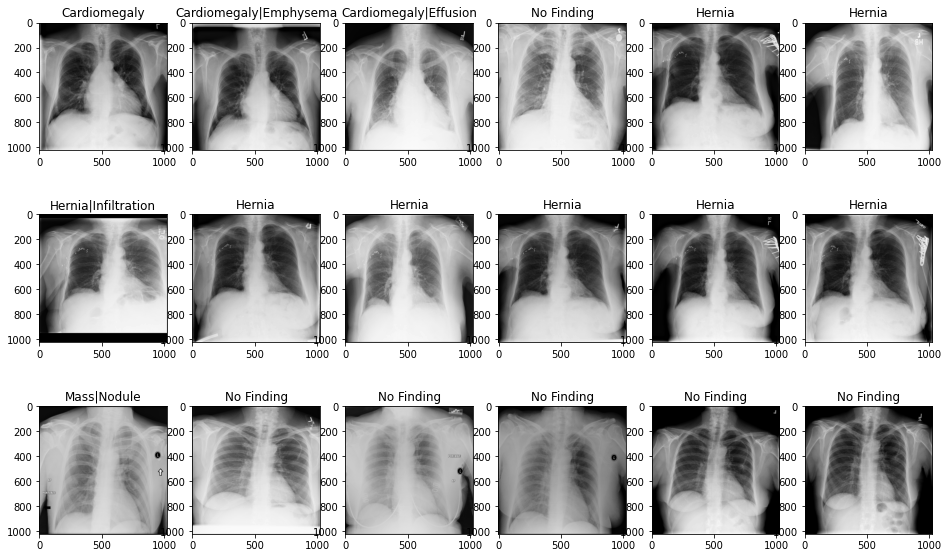

In [ ]:
# Explore the images
fig, axes = plt.subplots(3,6, figsize = (16,10))
ax = axes.flatten()

for i in range(18):
    imgplot = ax[i].imshow(col[i], cmap = 'gray')
    ax[i].set_title(labels_df['Finding Labels'][i])
plt.show()

In [ ]:
# Getting the dimensions of the pictures
for i in range(18):
    print(f'{i}|{col[i].shape}')

0|(1024, 1024)
1|(1024, 1024)
2|(1024, 1024)
3|(1024, 1024)
4|(1024, 1024)
5|(1024, 1024)
6|(1024, 1024)
7|(1024, 1024)
8|(1024, 1024)
9|(1024, 1024)
10|(1024, 1024)
11|(1024, 1024)
12|(1024, 1024, 4)
13|(1024, 1024)
14|(1024, 1024)
15|(1024, 1024)
16|(1024, 1024)
17|(1024, 1024)


Some images (like image 12) have an additional dimension so we will explore why.

100%|██████████| 4999/4999 [02:53<00:00, 28.86it/s]


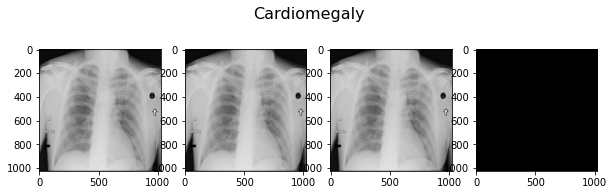

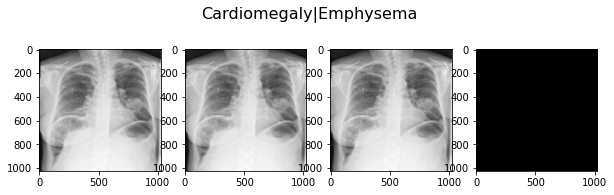

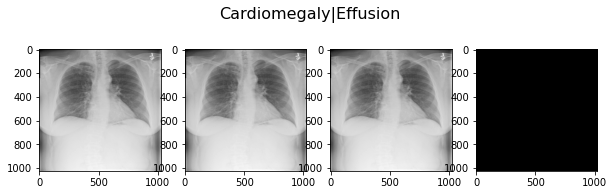

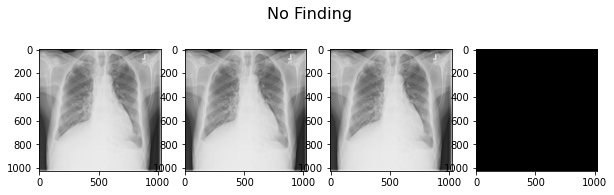

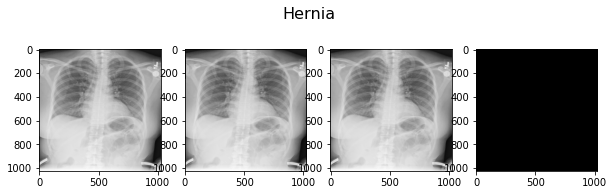

In [ ]:
# Get list of all images with more than two dimensions
multi_dims = []
tres_dim2 = []
for i in tqdm(range(len(col))):
    if len(col[i].shape)>2:
        multi_dims.append(i)
    else:
        tres_dim2.append(i)

# Seeing what the different dimensions 12th picture are
for j in range(5):
    fig, axes = plt.subplots(1,4, figsize = (10,3))
    ax = axes.flatten()
    fig.suptitle(labels_df['Finding Labels'][j], fontsize=16)
    for i in range(4):
        imgplot = ax[i].imshow(col[multi_dims[j]][:, :, i], cmap = 'gray')
    plt.show()

**Don't really see any relation for why some images have three dimensions. Now I will check to see if the images are all the same and if they are I will delete the repeats.**

In [ ]:
for k in range(5):
    
    #Checking to see if ever pixel is the same from the first picture to the second picture
    print(np.sum(col[multi_dims[k]][:, :, 0] == col[multi_dims[k]][:, :, 1])==1024*1024)
    
    #Checking to see if ever pixel is the same from the first picture to the third picture
    print(np.sum(col[multi_dims[k]][:, :, 0] == col[multi_dims[k]][:, :, 2])==1024*1024)

True
True
True
True
True
True
True
True
True
True


**It appears the extra dimension is meaningless so we will drop this from all images.**

In [ ]:
#Create list with all the images
im_list = []
for i in tqdm(range(len(col))):
    if len(col[i].shape)>2:
        im_list.append(col[i][:,:,-1])
    else:
        im_list.append(col[i])

100%|██████████| 4999/4999 [01:16<00:00, 65.04it/s]


In [ ]:
# Explore response Variable
print(np.unique(labels_df["Finding Labels"].values)[0:10])
labels_df["Finding Labels"].value_counts().count()

['Atelectasis' 'Atelectasis|Cardiomegaly'
 'Atelectasis|Cardiomegaly|Consolidation|Effusion'
 'Atelectasis|Cardiomegaly|Consolidation|Effusion|Mass'
 'Atelectasis|Cardiomegaly|Edema|Effusion|Infiltration|Pneumothorax'
 'Atelectasis|Cardiomegaly|Effusion'
 'Atelectasis|Cardiomegaly|Effusion|Infiltration'
 'Atelectasis|Cardiomegaly|Effusion|Mass'
 'Atelectasis|Cardiomegaly|Emphysema|Mass|Pneumothorax'
 'Atelectasis|Cardiomegaly|Fibrosis']


209

## Preprocess Data Frame

In [ ]:
# One hot encode response
dis = ['Infiltration','Atelectasis','Effusion', 'Nodule', 'Mass', 'Consolidation', 'Cardiomegaly', 'Emphysema']

main = pd.concat([labels_df,pd.DataFrame(columns=dis)]).fillna(0)

samp = main['Finding Labels'].str.split('|').apply(lambda x : [i for i in dis if i in x])

for i,j in enumerate(samp):
    for k in j:
        main.loc[i,k] = 1 
main.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Infiltration,Atelectasis,Effusion,Nodule,Mass,Consolidation,Cardiomegaly,Emphysema
0,00000001_000.png,Cardiomegaly,0.0,1.0,57.0,M,PA,2682.0,2749.0,0.143,0.143,0,0,0,0,0,0,1,0
1,00000001_001.png,Cardiomegaly|Emphysema,1.0,1.0,58.0,M,PA,2894.0,2729.0,0.143,0.143,0,0,0,0,0,0,1,1
2,00000001_002.png,Cardiomegaly|Effusion,2.0,1.0,58.0,M,PA,2500.0,2048.0,0.168,0.168,0,0,1,0,0,0,1,0
3,00000002_000.png,No Finding,0.0,2.0,80.0,M,PA,2500.0,2048.0,0.171,0.171,0,0,0,0,0,0,0,0
4,00000003_001.png,Hernia,0.0,3.0,74.0,F,PA,2500.0,2048.0,0.168,0.168,0,0,0,0,0,0,0,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0.5, 'Proportion'),
 Text(0.5, 0, 'Diagnosis'),
 Text(0.5, 1.0, 'Percent of Images with Given Diagnoses')]

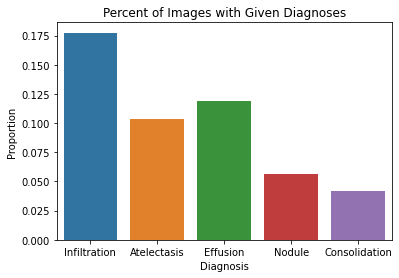

In [ ]:
# View distribution of response
x = ['Infiltration', 'Atelectasis', 'Effusion', "Nodule", 'Consolidation']
y = [0.17743489118801284, 0.10309489832322512, 0.11877452729218695, 0.05646628612201213, 0.0416250445950767]
import seaborn as sns
sns.barplot(x,y).set(xlabel='Diagnosis', ylabel='Proportion', title ='Percent of Images with Given Diagnoses')

In [ ]:
# One hot encode the rest of the labels
results = set()
labels_df['Finding Labels'].str.lower().str.split('|').apply(results.update)
print(results)

diag = list(results)

main = pd.concat([labels_df,pd.DataFrame(columns=diag)]).fillna(0)

samp = main['Finding Labels'].str.lower().str.split('|').apply(lambda x : [i for i in diag if i in x])

for i,j in enumerate(samp):
    for k in j:
        main.loc[i,k] = 1 
main.head()

{'no finding', 'hernia', 'atelectasis', 'pneumonia', 'pneumothorax', 'cardiomegaly', 'nodule', 'effusion', 'pleural_thickening', 'emphysema', 'infiltration', 'edema', 'fibrosis', 'mass', 'consolidation'}


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,cardiomegaly,nodule,effusion,pleural_thickening,emphysema,infiltration,edema,fibrosis,mass,consolidation
0,00000001_000.png,Cardiomegaly,0.0,1.0,57.0,M,PA,2682.0,2749.0,0.143,...,1,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1.0,1.0,58.0,M,PA,2894.0,2729.0,0.143,...,1,0,0,0,1,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2.0,1.0,58.0,M,PA,2500.0,2048.0,0.168,...,1,0,1,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0.0,2.0,80.0,M,PA,2500.0,2048.0,0.171,...,0,0,0,0,0,0,0,0,0,0
4,00000003_001.png,Hernia,0.0,3.0,74.0,F,PA,2500.0,2048.0,0.168,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Print means for response
mean_y = []
for i in diag:
  mean_y.append(main[i].mean())
  print(i)
  print(main[i].mean())

no finding
0.5509101820364073
hernia
0.0054010802160432084
atelectasis
0.09201840368073615
pneumonia
0.01300260052010402
pneumothorax
0.03980796159231846
cardiomegaly
0.03920784156831366
nodule
0.04280856171234247
effusion
0.09741948389677936
pleural_thickening
0.033006601320264055
emphysema
0.02500500100020004
infiltration
0.16603320664132826
edema
0.01800360072014403
fibrosis
0.034406881376275254
mass
0.03220644128825765
consolidation
0.04100820164032806


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'no finding'),
 Text(0, 0, 'hernia'),
 Text(0, 0, 'atelectasis'),
 Text(0, 0, 'pneumonia'),
 Text(0, 0, 'pneumothorax'),
 Text(0, 0, 'cardiomegaly'),
 Text(0, 0, 'nodule'),
 Text(0, 0, 'effusion'),
 Text(0, 0, 'pleural_thickening'),
 Text(0, 0, 'emphysema'),
 Text(0, 0, 'infiltration'),
 Text(0, 0, 'edema'),
 Text(0, 0, 'fibrosis'),
 Text(0, 0, 'mass'),
 Text(0, 0, 'consolidation')]

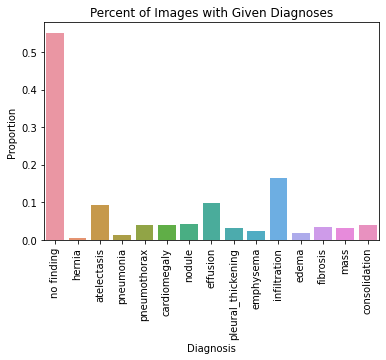

In [ ]:
x = diag
y = mean_y
import seaborn as sns
ax = sns.barplot(x,y)
ax.set(xlabel='Diagnosis', ylabel='Proportion', title ='Percent of Images with Given Diagnoses')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

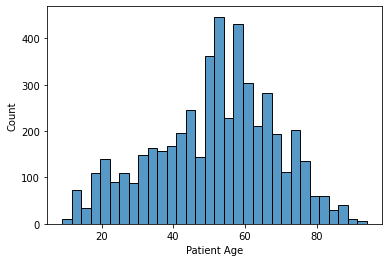

In [ ]:
# More data exploration
sns.histplot(main['Patient Age'])

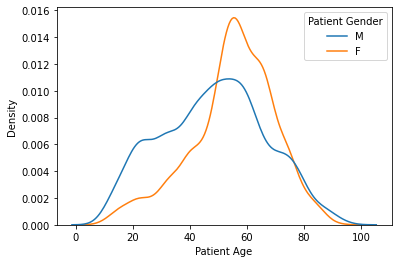

In [ ]:
sns.kdeplot(data=main, x="Patient Age", hue="Patient Gender")

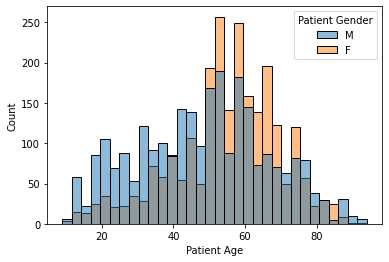

In [ ]:
sns.histplot(data=main, x="Patient Age", hue="Patient Gender")

## Preliminary tf model

In [ ]:
#Creating small sample for preliminary model
y_samp = main['infiltration'][0:500]
X_samp = im_list[0:500]
assert len(X_samp)==len(y_samp)

In [ ]:
#Checking rate of infiltration in sample
np.mean(y_samp)

0.2

In [ ]:
def build_model(num_filts):
  model = Sequential()
  model.add(Conv2D(num_filts[0], kernel_size = 1, activation = 'relu', input_shape=(1024, 1024, 1), padding = 'same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(num_filts[1], kernel_size = 1, activation = 'relu', input_shape=(1024, 1024, 1), padding = 'same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(num_filts[2], kernel_size = 1, activation = 'relu', input_shape=(1024, 1024, 1), padding = 'same'))
  model.add(Conv2D(num_filts[2], kernel_size = 1, activation = 'relu', input_shape=(1024, 1024, 1), padding = 'same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(32, activation = 'relu'))
  model.add(Dropout(0.25))
  model.add(Dense(1, activation = 'sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
  return model

In [ ]:
model1 = build_model([16,16,16])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1024, 1024, 16)    32        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 512, 512, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 512, 512, 16)      272       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 256, 256, 16)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 16)      272       
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      2

In [ ]:
X_train = np.asarray(X_samp)
y_tensor = tf.convert_to_tensor(y_samp, dtype=tf.int64)
X_tensor = tf.convert_to_tensor(X_train, dtype=tf.int64)

In [ ]:
epochs = 5
history = model1.fit(X_tensor, y_tensor, batch_size=32, validation_split = 0.2, epochs=epochs, verbose=1)

Epoch 1/5
13/13 [==============================] - 16s 420ms/step - loss: 29.2016 - accuracy: 0.6825 - val_loss: 0.6931 - val_accuracy: 0.9000
Epoch 2/5
13/13 [==============================] - 4s 326ms/step - loss: 0.6930 - accuracy: 0.7750 - val_loss: 0.6928 - val_accuracy: 0.9000
Epoch 3/5
13/13 [==============================] - 4s 327ms/step - loss: 0.6932 - accuracy: 0.7700 - val_loss: 0.6923 - val_accuracy: 0.9000
Epoch 4/5
13/13 [==============================] - 4s 324ms/step - loss: 0.6924 - accuracy: 0.7750 - val_loss: 0.6918 - val_accuracy: 0.9000
Epoch 5/5
13/13 [==============================] - 4s 321ms/step - loss: 0.6921 - accuracy: 0.7750 - val_loss: 0.6913 - val_accuracy: 0.9000


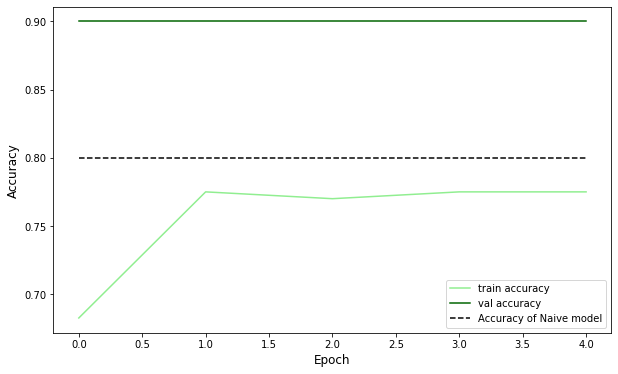

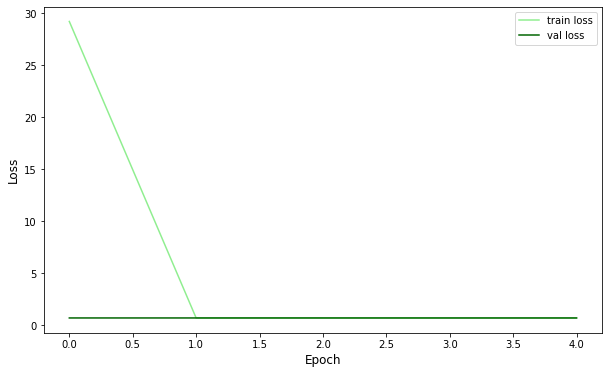

In [ ]:
#Create Figure
fig, ax1 = plt.subplots(1, 1, figsize=(10,6))

#Plot Train and Validation accuracy
ax1.plot((model1.history.history['accuracy']), color='lightgreen' ,label='train accuracy')
ax1.plot((model1.history.history['val_accuracy']), color='darkgreen' ,label='val accuracy')
ax1.hlines(0.8,0,epochs-1, color = 'black', linestyle = '--', label = 'Accuracy of Naive model')
ax1.set_xlabel(r'Epoch', fontsize=12)
ax1.set_ylabel(r'Accuracy', fontsize=12)
ax1.tick_params(axis='y')
ax1.legend(loc = 'best')
plt.show()

#Create second figure
fig2, ax2 = plt.subplots(1, 1, figsize=(10,6))

#Plot Train and Validation loss
ax2.plot((model1.history.history['loss']), color='lightgreen', label='train loss')
ax2.plot((model1.history.history['val_loss']), color='darkgreen', label='val loss')
ax2.set_ylabel(r'Loss', fontsize=12)
ax2.set_xlabel(r'Epoch', fontsize=12)
ax2.tick_params(axis='y')
ax2.legend(loc = 'best')
plt.show()

**The tf model requires too much RAM and google colab crashes. We will try pipelining using pytorch instead.**

## Build pytorch model

In [ ]:
! pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=bd910e254ef449a69d45e30692ec387311ffb567b921105074ce2fb9975351d8
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [ ]:
# I have used Efficientnet3 pre-trained model for the classification task
from efficientnet_pytorch import EfficientNet

##Please copy and paste the path of the directory where the dataset folder is present in the line below
BASE_PATH='gdrive/MyDrive/209_project/'
train_dataset=pd.read_csv('gdrive/MyDrive/209_project/Data_Entry_2017_v2020.csv')
#test_dataset=pd.read_csv(os.path.join(BASE_PATH,'test_labels.csv'))

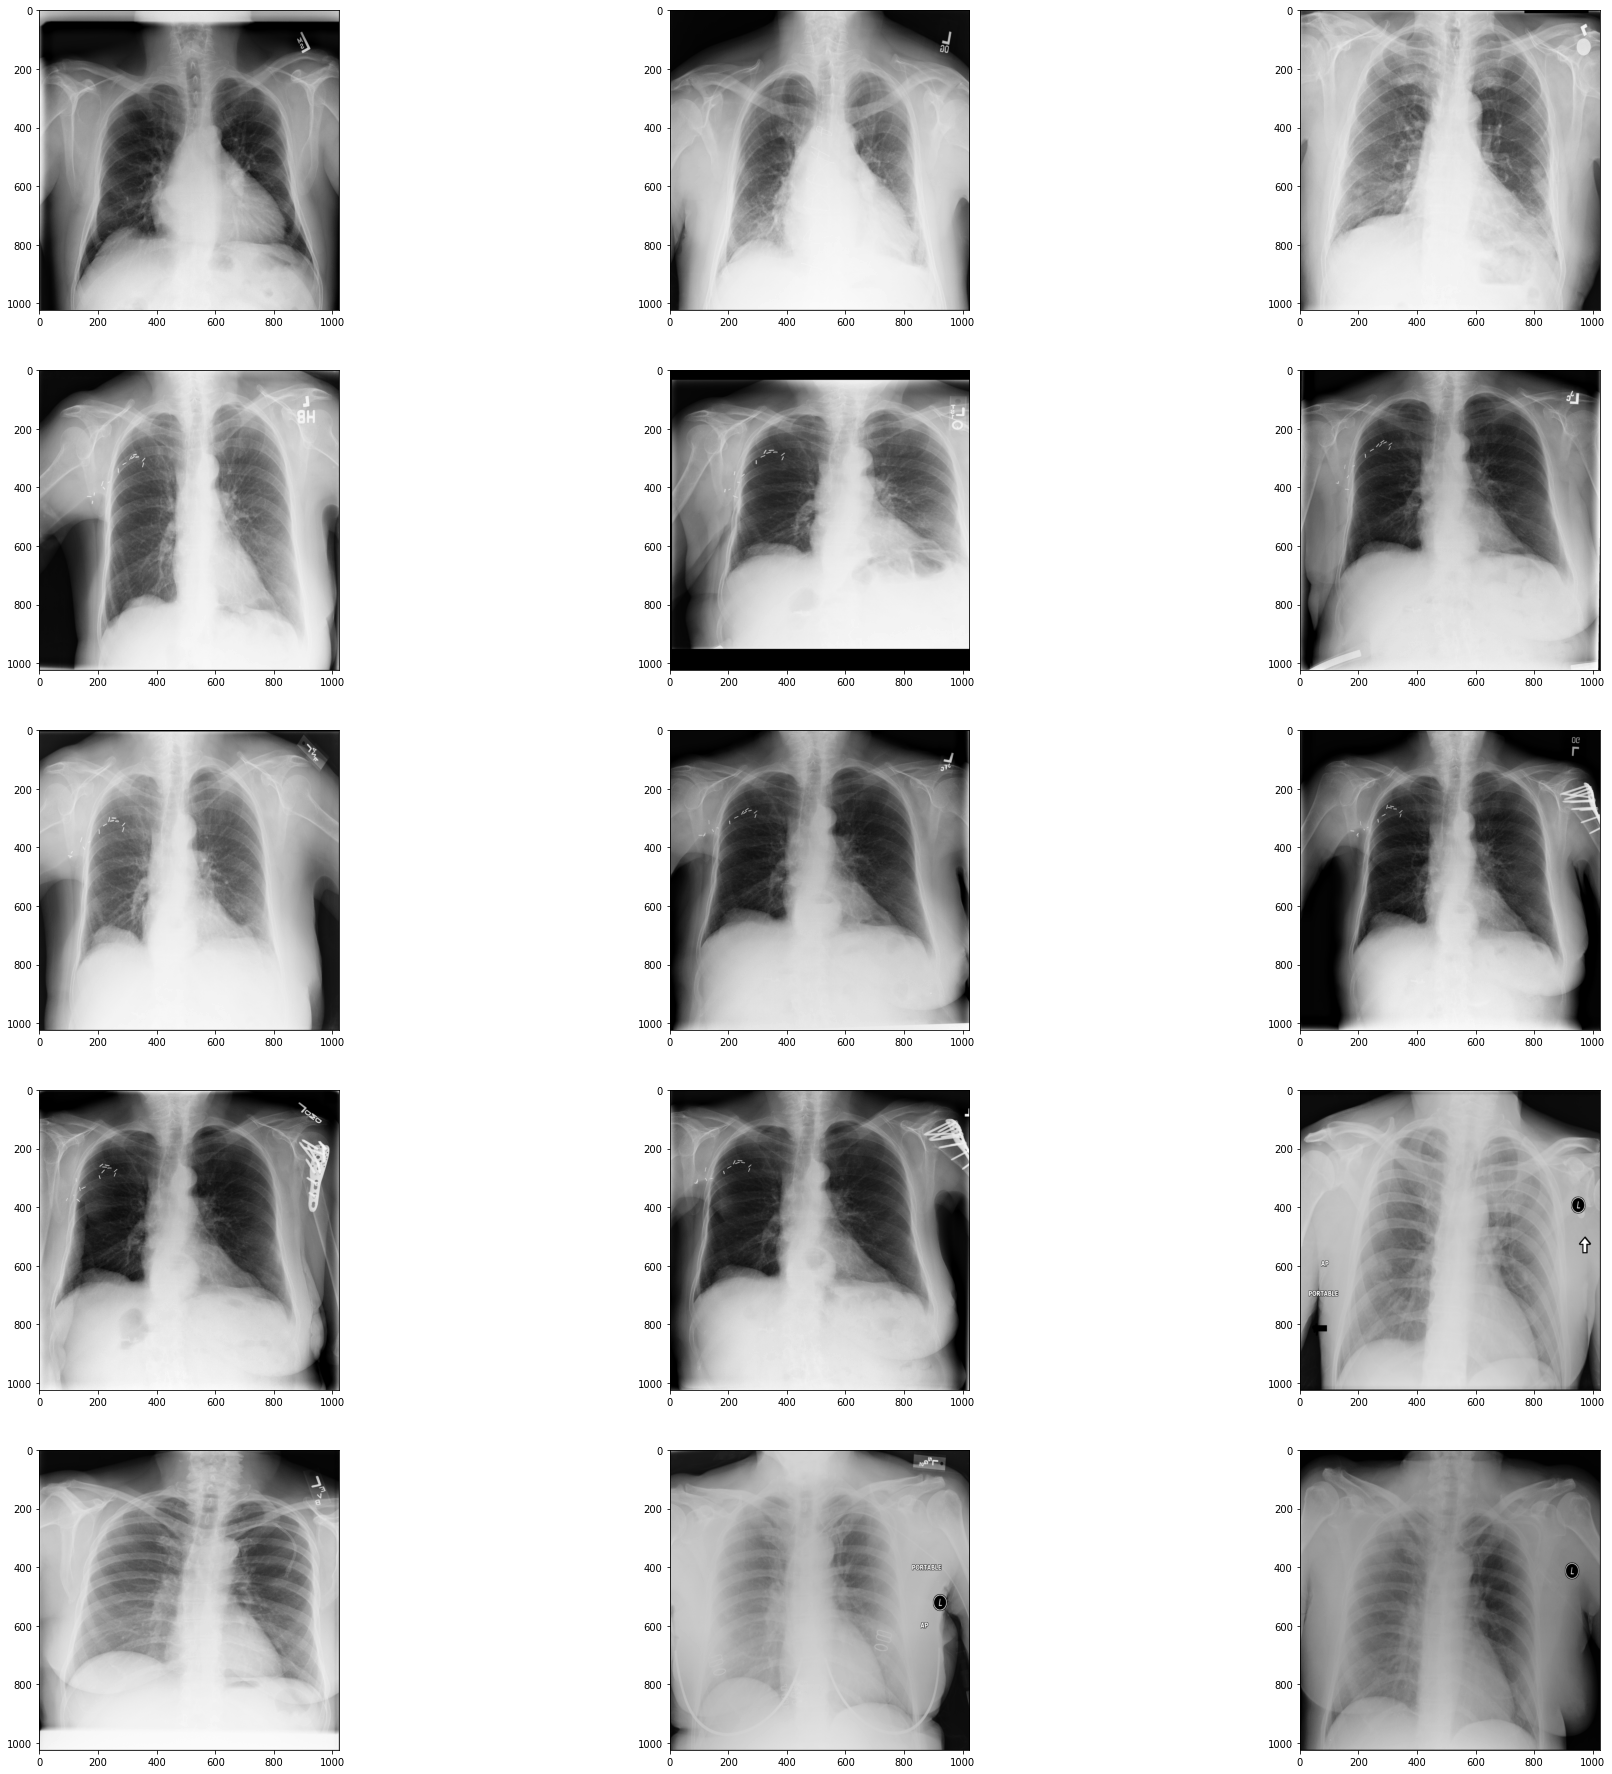

In [ ]:
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(32, 32)) #Size of Figure
columns = 3 #Number of Columns in the figure
rows = 5 #Number of Rows in the figure
# The number of images will be 15 ( Number of Columns * Number of Rows ) 
for i in range(1,rows*columns+1):
    IMG_PATH='gdrive/MyDrive/209_project/images/'
    img=Image.open(os.path.join(IMG_PATH,train_dataset.iloc[i][0]))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
class Dataset(data.Dataset):
    def __init__(self,csv_path,images_path,transform=None):
        self.train_set=pd.read_csv(csv_path).iloc[0:5000-1, :] #Read The CSV and then create the dataframe
        #self.train_set=self.train_set
        self.train_path=images_path #Path where images are present
        self.transform=transform # The transform function for augmenting images
    def __len__(self):
        return len(self.train_set)
    
    def __getitem__(self,idx):
        file_name=self.train_set.iloc[idx][0] 
        label=self.train_set.iloc[idx][1]
        img=Image.open(os.path.join(self.train_path,file_name)) #Loading Image
        if self.transform is not None:
            img=self.transform(img)
        return img,label

In [ ]:
training_set_untransformed=Dataset('gdrive/MyDrive/209_project/Data_Entry_2017_v2020.csv','gdrive/MyDrive/209_project/images/')


In [ ]:
transform_train = transforms.Compose([transforms.Resize((224,224)),transforms.RandomApply([
        torchvision.transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip()],0.7),
		transforms.ToTensor()])

In [ ]:
new_created_images=[]
for j in tqdm(range(len(training_set_untransformed))):
  transformed_image = transform_train(training_set_untransformed[j][0])
  new_created_images.append((transformed_image,0))

 55%|█████▍    | 2737/4999 [00:56<00:46, 48.18it/s]


KeyboardInterrupt: ignored

In [ ]:
train_size = int(0.8 * len(new_created_images))
validation_size = len(new_created_images) - train_size
train_dataset, validation_dataset = torch.utils.data.random_split(new_created_images, [train_size,validation_size])


In [ ]:
training_generator = data.DataLoader(train_dataset,shuffle=True,batch_size=32,pin_memory=True)

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b3', num_classes=836)

In [ ]:
model.to(device);

In [ ]:
criterion = nn.CrossEntropyLoss()
lr_decay=0.99
optimizer = optim.Adam(model.parameters(), lr=1e-4)
history_accuracy=[]
history_loss=[]
epochs = 11

In [ ]:
classes = list(np.unique(labels_df['Finding Labels'].values))

In [ ]:
for epoch in range(epochs):  
    running_loss = 0.0
    correct=0
    total=0
    class_correct = list(0. for _ in classes)
    class_total = list(0. for _ in classes)
    
    for i, data in enumerate(training_generator, 0):
        inputs, labels = data
        t0 = time()
        inputs, labels = inputs.to(device), labels.to(device)
        labels = np.eye(len(labels))
        optimizer.zero_grad()
        #torch.cuda.empty_cache()
        outputs = model(inputs)
        loss = criterion(outputs, torch.max(labels, 1)[1])
        _, predicted = torch.max(outputs, 1)
        _, labels = torch.max(labels, 1)
        c = (predicted == labels.data).squeeze()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        accuracy = float(correct) / float(total)
        
        history_accuracy.append(accuracy)
        history_loss.append(loss)
        
        loss.backward()
        optimizer.step()
        
        for j in range(labels.size(0)):
            label = labels[j]
            class_correct[label] += c[j].item()
            class_total[label] += 1
        
        running_loss += loss.item()
        
        print( "Epoch : ",epoch+1," Batch : ", i+1," Loss :  ",running_loss/(i+1)," Accuracy : ",accuracy,"Time ",round(time()-t0, 2),"s" )
    
    for k in range(len(classes)):
        if(class_total[k]!=0):
            print('Accuracy of %5s : %2d %%' % (classes[k], 100 * class_correct[k] / class_total[k]))
            
            print('[%d epoch] Accuracy of the network on the Training images: %d %%' % (epoch+1, 100 * correct / total))
    
    if epoch%10==0 or epoch==0:
        torch.save(model.state_dict(), os.path.join(PATH_SAVE,str(epoch+1)+'_'+str(accuracy)+'.pth'))
      

In [ ]:
class Dataset(data.Dataset):
    def __init__(self,csv_path,images_path,transform=None):
        self.train_set=pd.read_csv(csv_path) #Read The CSV and then create the dataframe
        self.train_path=images_path #Path where images are present
        self.transform=transform # The transform function for augmenting images
    def __len__(self):
        return len(self.train_set)
    
    def __getitem__(self,idx):
        file_name=self.train_set.iloc[idx][0] 
        label=self.train_set.iloc[idx][1]
        img=Image.open(os.path.join(self.train_path,file_name)) #Loading Image
        if self.transform is not None:
            img=self.transform(img)
        return img,label
training_set_untransformed=Dataset('gdrive/MyDrive/209_project/Data_Entry_2017_v2020.csv','gdrive/MyDrive/209_project/images/*.png')


In [ ]:
import numpy as np 
import pandas as pd
import os
from torchsummary import summary
import PIL
import sys
import torch
from time import time
import torchvision
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.autograd import Variable
import torchvision.transforms as transforms

# I have used Efficientnet3 pre-trained model for the classification task
from efficientnet_pytorch import EfficientNet

##Please copy and paste the path of the directory where the dataset folder is present in the line below
BASE_PATH='/home/bharat/Desktop/STAT_946_Data_Challenge_1/..../data'
train_dataset=pd.read_csv(os.path.join(BASE_PATH,'train_labels.csv'))
test_dataset=pd.read_csv(os.path.join(BASE_PATH,'test_labels.csv'))

In [ ]:
#tok_lab = labels_df["Finding Labels"].apply(lambda x: [z for y in x for z in y.strip("|").lower().split()])
s = [[z for y in x for z in y.strip("|").lower().split()] for x in labels_df["Finding Labels"]]
print(s)